## Counting Trigrams


In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np

%matplotlib inline

In [2]:
words = open("../makemore/names.txt", "r").read().splitlines()
len(words), words[0:3]

(32033, ['emma', 'olivia', 'ava'])

In [3]:
# 27 * 27 * 27 is probably the right shape, but my brain hurts trying to figure
# out the correct dimensions for vectorized operations
N3 = torch.zeros((27, 27, 27), dtype=torch.int32)

# 729 * 27 is much simpler to work with vs 27 * 27 * 27
N = N3.view((27 * 27, 27))

In [4]:
chars = sorted(list(set("".join(words))))

stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {s: i for i, s in stoi.items()}

In [5]:
for w in words:
    chs = [".", "."] + list(w) + ["."]
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        ix1, ix2, ix3 = stoi[ch1], stoi[ch2], stoi[ch3]
        N3[ix1, ix2, ix3] += 1

In [6]:
assert N3[stoi["r"], stoi["a"], stoi["c"]] == 103
assert N[stoi["r"] * 27 + stoi["a"], stoi["c"]] == 103

In [7]:
# Exercise for the reader, how do I do this with a 27*27*27 (N3) tensor?
P = N.float() / N.sum(1, keepdim=True)

In [8]:
# Probability of the starting token
print(P[0])
values, indices = torch.topk(P[0], 7)
{itos[i.item()]: f"{p * 100:.1f}%" for i, p in zip(indices, values)}

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])


{'a': '13.8%',
 'k': '9.2%',
 'm': '7.9%',
 'j': '7.6%',
 's': '6.4%',
 'd': '5.3%',
 'r': '5.1%'}

In [9]:
# Verify that each row of P if valid adds up to 1 or is nan.
for i in range(729):
    sum = P[i].sum()

    nan = torch.isnan(sum).any().item()
    small = torch.isclose(sum, torch.tensor(1.0)).item()

    if (not small) and (not nan):
        print(f"{i} {itos[i//27]}{itos[i%27]} {sum=} {nan=} {small=}")
        raise

In [10]:
g = torch.Generator().manual_seed(2147483647 + 2)


def make_name() -> str:
    out, ix1, ix2, ix3 = [], 0, 0, -1
    while ix3 != 0:
        p = P[ix1 * 27 + ix2]
        ix3 = torch.multinomial(
            p,  #
            num_samples=1,
            replacement=False,
            generator=g,
        ).item()

        if ix3 != 0:
            out.append(itos[ix3])
        ix1, ix2 = ix2, ix3

    return "".join(out)


[make_name() for _ in range(10)]

['taylor',
 'keigelielillagaurjoandalana',
 'marquann',
 'lonniah',
 'zamdennet',
 'artymaya',
 'que',
 'kenna',
 'mond',
 'jaarneshilleschamilynneifen']

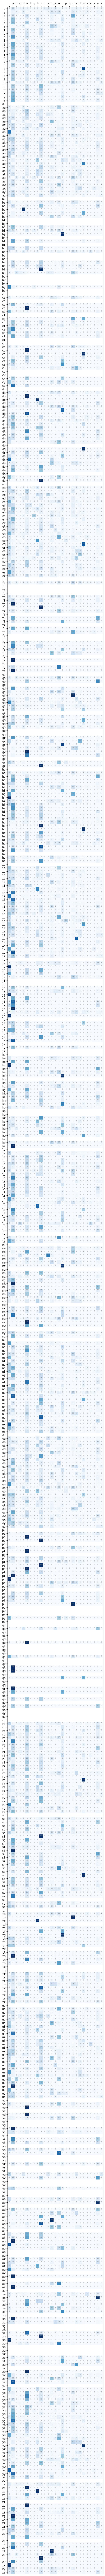

In [11]:
plt.figure(figsize=(16, 160))
plt.imshow(P, cmap="Blues")
plt.yticks(
    ticks=np.arange(27 * 27),
    labels=[itos[i] + itos[j] for i in range(27) for j in range(27)],
    fontfamily="monospace",
)
plt.xticks(
    ticks=np.arange(27),
    labels=[itos[i] for i in range(27)],
    fontfamily="monospace",
)
ax = plt.gca()
ax.xaxis.set_ticks_position("top")

for i in range(27 * 27):
    for j in range(27):
        if not P[i, j].isnan():
            text = f"{P[i, j].item() * 100:.0f}"
            plt.text(j, i, text, ha="center", va="bottom", color="gray", fontsize=5)
# Skipping colorbar gives a bit more horizontal space,
# also not really needed for probabilities.
# plt.colorbar();